<a href="https://colab.research.google.com/github/sayyed-uoft/fullstackai/blob/main/10_Working_with_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strata.ai - Artificial Intelligence Certificate
# Module 1: Data Science for AI
# Working with SQL
Source: hhttps://www.dataquest.io/blog/python-pandas-databases/

## Importing pandas and SQLite packages

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

%matplotlib inline

## Loading the database file and creating a connection

In [65]:
!wget https://github.com/sayyed-uoft/fullstackai/raw/main/flights.db

--2022-01-10 20:48:53--  https://github.com/sayyed-uoft/fullstackai/raw/main/flights.db
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sayyed-uoft/fullstackai/main/flights.db [following]
--2022-01-10 20:48:54--  https://raw.githubusercontent.com/sayyed-uoft/fullstackai/main/flights.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5415936 (5.2M) [application/octet-stream]
Saving to: ‘flights.db.1’

flights.db.1        100%[===================>]   5.17M  --.-KB/s    in 0.05s   

2022-01-10 20:48:54 (94.6 MB/s) - ‘flights.db.1’ saved [5415936/5415936]



In [3]:
conn = sqlite3.connect("flights.db")

## Reading and querying a table

Once we have a connection we can create a cursor. Cursors allow us to execute SQL queries against a database:

In [4]:
cur = conn.cursor()

Let's define a SELECT query to get all rows from "airlines table:

In [5]:
cur.execute("select * from airlines;")

You can see the column names from "cur.description":

In [6]:
for col in cur.description:
  print(col[0])

index
id
name
alias
iata
icao
callsign
country
active


We can fetch one row at the time:

In [7]:
row = cur.fetchone()
row

(0, '1', 'Private flight', '\\N', '-', None, None, None, 'Y')

In [8]:
type(row)

tuple

We can also fetch all at the same time. Let's change the query to limit it to 5 rows:

In [10]:
cur.execute("select * from airlines limit 5;")
results = cur.fetchall()
results

[(0, '1', 'Private flight', '\\N', '-', None, None, None, 'Y'),
 (1, '2', '135 Airways', '\\N', None, 'GNL', 'GENERAL', 'United States', 'N'),
 (2, '3', '1Time Airline', '\\N', '1T', 'RNX', 'NEXTIME', 'South Africa', 'Y'),
 (3,
  '4',
  '2 Sqn No 1 Elementary Flying Training School',
  '\\N',
  None,
  'WYT',
  None,
  'United Kingdom',
  'N'),
 (4, '5', '213 Flight Unit', '\\N', None, 'TFU', None, 'Russia', 'N')]

At the end we should close both the cursor and the connection:

In [11]:
cur.close()
conn.close()

## Mapping Airports

Let's create a map of flights:

First we run a query to get the coordinates

In [12]:
conn = sqlite3.connect("flights.db")
cur = conn.cursor()
coords = cur.execute("""
select cast(longitude as float),
cast(latitude as float)
from airports;""").fetchall()

In [13]:
len(coords)

8107

To plot a mps, we need to install "basemap" package first:

In [19]:
!pip install basemap

     |████████████████████████████████| 858 kB 6.7 MB/s 
     |████████████████████████████████| 219 kB 55.7 MB/s 
     |████████████████████████████████| 30.5 MB 80.8 MB/s 
     |████████████████████████████████| 6.3 MB 27.4 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=b1b2799545d8d4a391f54c3cc1acc98990f0739ccf513c9b0b2b7f8a471661a7
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


In [25]:
from mpl_toolkits.basemap import Basemap
plt.rcParams["figure.figsize"] = (8, 6)

We setup our map, and draw the continents and coastlines that will form the background of our map. We also plot the coordinates of each airport onto the map:

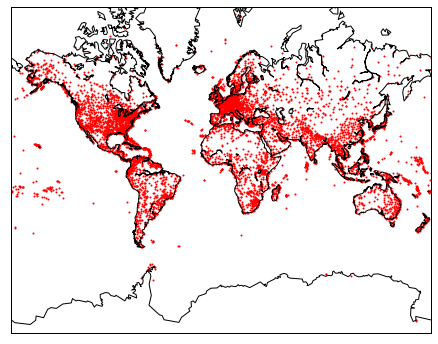

In [26]:
m = Basemap(
projection='merc',
llcrnrlat=-80,
urcrnrlat=80,
llcrnrlon=-180,
urcrnrlon=180,
lat_ts=20,
resolution='c')

m.drawcoastlines()
m.drawmapboundary()

x, y = m([l[0] for l in coords], [l[1] for l in coords])
m.scatter(x, y, 1, marker='o', color='red')

plt.show()

In [27]:
cur.close()
conn.close()

## Reading results into a pandas DataFrame

In [28]:
conn = sqlite3.connect("flights.db")
df = pd.read_sql_query("select * from airlines limit 5;", conn)
df

,index,id,name,alias,iata,icao,callsign,country,active
0,0,1,Private flight,\N,-,None,None,None,Y
1,1,2,135 Airways,\N,None,GNL,GENERAL,United States,N
2,2,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
3,3,4,2 Sqn No 1 Elementary Flying Training School,\N,None,WYT,None,United Kingdom,N
4,4,5,213 Flight Unit,\N,None,TFU,None,Russia,N


In [37]:
conn.close()

## Modifying Database Rows

In [38]:
conn = sqlite3.connect("flights.db")

### Inserting rows with Python

In [39]:
cur = conn.cursor()
cur.execute("insert into airlines values (6048, 19846, 'Test flight', '', '', null, null, null, 'Y')")

In [40]:
conn.commit()

Let's check:

In [41]:
cur.execute('select * from airlines where id = 19846').fetchall()

[(6048, '19846', 'Test flight', '', '', None, None, None, 'Y')]

Another method:

In [42]:
pd.read_sql_query("select * from airlines where id=19846;", conn)

,index,id,name,alias,iata,icao,callsign,country,active
0,6048,19846,Test flight,,,None,None,None,Y


### Passing parameters into a query

The hard way (without parameters):

In [46]:
cur = conn.cursor()
name = "Test Flight"
cur.execute("insert into airlines values (6049, 19847, '{0}', '', '', null, null, null, 'Y')".format(name))
conn.commit()

Inserting values with Python string formatting makes your program vulnerable to SQL Injection attacks.

In [47]:
cur = conn.cursor()
values = ('Test Flight', 'Y')
cur.execute("insert into airlines values (6049, 19847, ?, '', '', null, null, null, ?)", values)
conn.commit()

### Updating rows

In [48]:
cur = conn.cursor()
values = ('USA', 19847)
cur.execute("update airlines set country=? where id=?", values)
conn.commit()

In [49]:
pd.read_sql_query("select * from airlines where id=19847;", conn)

,index,id,name,alias,iata,icao,callsign,country,active
0,6049,19847,Test Flight,,,None,None,USA,Y
1,6049,19847,Test Flight,,,None,None,USA,Y


### Deleting rows

In [51]:
cur = conn.cursor()
values = (19847, )
cur.execute("delete from airlines where id=?", values)
conn.commit()

In [52]:
pd.read_sql_query("select * from airlines where id=19847;", conn)

,index,id,name,alias,iata,icao,callsign,country,active


## Creating tables

We can create tables by executing a SQL query. We can create a table to represent each daily flight on a route, with the following columns:

* **id** — integer
* **departure** — date, when the flight left the airport
* **arrival** — date, when the flight arrived at the destination
* **number** — text, the flight number
* route_id — integer, the id of the route the flight was flying

In [53]:
cur = conn.cursor()
cur.execute("create table daily_flights (id integer, departure date, arrival date, number text, route_id integer)")
conn.commit()


In [55]:
cur.execute("insert into daily_flights values (1, '2016-09-28 0:00', '2016-09-28 12:00', 'T1', 1)")
conn.commit()

In [56]:
pd.read_sql_query("select * from daily_flights;", conn)

,id,departure,arrival,number,route_id
0,1,2016-09-28 0:00,2016-09-28 12:00,T1,1
1,1,2016-09-28 0:00,2016-09-28 12:00,T1,1


## Creating tables with pandas

In [57]:
from datetime import datetime

df = pd.DataFrame(
  [[1, datetime(2016, 9, 29, 0, 0) ,
  datetime(2016, 9, 29, 12, 0), 'T1', 1]],
  columns=["id", "departure", "arrival", "number", "route_id"])

In [58]:
df.to_sql("daily_flights", conn, if_exists="replace")

In [59]:
pd.read_sql_query("select * from daily_flights;", conn)

,index,id,departure,arrival,number,route_id
0,0,1,2016-09-29 00:00:00,2016-09-29 12:00:00,T1,1


## Altering Tables

In [61]:
cur.execute("alter table airlines add column airplanes integer;")

OperationalError: ignored

In [62]:
pd.read_sql_query("select * from airlines limit 1;", conn)

,index,id,name,alias,iata,icao,callsign,country,active,airplanes
0,0,1,Private flight,\N,-,None,None,None,Y,None


## Altering tables with Pandas

In [63]:
df = pd.read_sql("select * from daily_flights", conn)

df["delay_minutes"] = None

df.to_sql("daily_flights", conn, if_exists="replace")

In [64]:
pd.read_sql_query("select * from daily_flights;", conn)

,level_0,index,id,departure,arrival,number,route_id,delay_minutes
0,0,0,1,2016-09-29 00:00:00,2016-09-29 12:00:00,T1,1,None
